# Asset Allocation

[Process]

- K-mean clustering으로 2023년, 2022년, 2021년 수익률, 변동성 기준으로 군집화 --> 교집합이 적음 --> 3가지 해결방안 메모. --> 혹은 아래의 Modularity Network도 적용해봄.

- Modularity Network으로 2023년 수익률, 변동성 기준으로  군집화 후 모멘텀 종목 선정 --> 벤치마크를 2.5배 가량 상회하는 성과 --> 이번엔 모멘텀이 아닌 밸류지표 적용 방안 고민.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Import Model Packages
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, metrics
from pykrx import stock
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings(action='ignore')

# Louvain 알고리즘, Modularity network

In [2]:
# !pip install networkx python-louvain
import networkx as nx
import community as community_louvain

In [ ]:
'''
# 그래프 생성 (예시)
G = nx.karate_club_graph()  # NetworkX에 내장된 예시 그래프 (Karate Club 그래프)

# Louvain 알고리즘을 사용한 커뮤니티 탐지
partition = community_louvain.best_partition(G)

# 각 노드의 커뮤니티 출력
print("각 노드의 커뮤니티: ", partition)

# 그래프 시각화
pos = nx.spring_layout(G)  # 노드 배치 레이아웃
cmap = plt.get_cmap('viridis')  # 색상맵

# 각 커뮤니티에 따른 노드 색상 지정
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=300,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# 그래프 출력
plt.show()

# Modularity 계산
modularity_value = community_louvain.modularity(partition, G)
print(f"Modularity: {modularity_value}")
''''

# 1) 2023년 Modularity

In [117]:
file_path = ('kospi200_stocks.xlsx')
df = pd.read_excel(file_path, sheet_name=0, header=None) # 엑셀 파일 첫 번째 시트
data = df.iloc[14:].reset_index(drop=True) # 14번째 행부터 데이터프레임의 데이터를 가져오도록 설정
data.columns = df.iloc[8]  # 8번째 행을 컬럼명으로 설정
data = data.rename(columns={data.columns[0]: 'date'})  # 첫 번째 컬럼 이름을 'date'로 변경
data['date'] = pd.to_datetime(data['date'], errors='coerce')  # 날짜 형식 변환
data = data.set_index(data.columns[0]) # 첫 번째 열을 인덱스로 설정하고 해당 열 제거
data.index = pd.to_datetime(data.index, errors='coerce') # 인덱스를 datetime 형식으로 변환

data.columns.name = 'Code'  # 종목 코드에 이름 설정
data.index.name = 'Date'    # 날짜 인덱스에 이름 설정

# 1년치 데이터 사용
dataset_1st_year = data.loc['2023-01-01':'2023-12-31',:]
dataset_1st_year.head(10)

Code,A005930,A000660,A373220,A207940,A005380,A068270,A000270,A105560,A005490,A055550,...,A005250,A093370,A003030,A001680,A009900,A016380,A000670,A105630,A178920,A008730
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,55300,75000,435500,821000,151000,160500,59300,48500,276500,35200,...,17000,10450,146500,21900,14350,7390,605000,15400,28900,36450
2023-01-02,55500,75700,446000,827000,157000,160000,61500,47600,272000,34300,...,16600,10352,142000,21450,14450,7150,584000,14750,28900,36150
2023-01-03,55400,75600,440500,803000,159000,159000,62400,49050,272000,35000,...,16300,10499,146500,21150,14800,7260,583000,14450,29600,36550
2023-01-04,57800,81000,443000,794000,160500,160500,62000,50500,274500,36400,...,16500,10645,150000,20900,14700,7310,613000,15150,28900,37050
2023-01-05,58200,81400,433500,808000,159000,163000,61100,53900,278500,39450,...,16500,10401,141000,20950,14600,7440,610000,14700,27850,37150
2023-01-06,59000,83100,444000,808000,159500,163500,61500,56700,286000,40600,...,16500,10743,142500,20950,14800,7520,610000,14850,28250,37150
2023-01-07,59000,83100,444000,808000,159500,163500,61500,56700,286000,40600,...,16500,10743,142500,20950,14800,7520,610000,14850,28250,37150
2023-01-08,59000,83100,444000,808000,159500,163500,61500,56700,286000,40600,...,16500,10743,142500,20950,14800,7520,610000,14850,28250,37150
2023-01-09,60700,86000,464000,812000,164000,166000,64100,57200,289000,40350,...,17050,11036,147000,21300,15150,7710,624000,15500,30200,38300


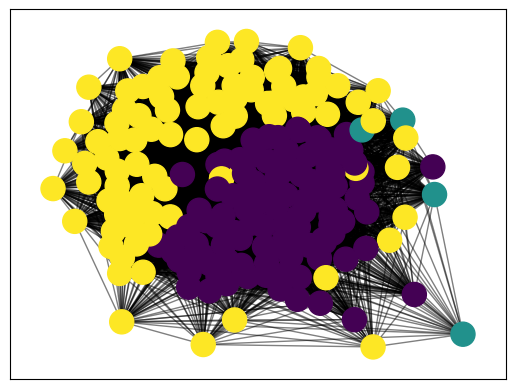

Modularity: 0.1408230295577625


In [118]:
returns_df = dataset_1st_year.copy()

# 2. 상관 행렬 계산 (자산 간 상관관계)
correlation_matrix = returns_df.corr()

# 3. 상관 행렬을 네트워크로 변환
G = nx.Graph()

# 3. 상관 행렬을 네트워크로 변환
G = nx.Graph()

# 상관관계가 높은 자산들 간에만 엣지를 추가 (절대값 사용)
threshold = 0.3  # 임계값 설정. 0.1 / 0.3 / 0.5 해보기.
for i in range(len(correlation_matrix)):
    for j in range(i + 1, len(correlation_matrix)):
        weight = abs(correlation_matrix.iloc[i, j])  # 상관관계의 절대값 사용
        if weight > threshold:
            G.add_edge(correlation_matrix.index[i], correlation_matrix.columns[j], weight=weight)

# 만약 그래프에 엣지가 없는 경우, 임의로 연결 추가 (최소 연결 강제)
if G.number_of_edges() == 0:
    print("연결이 없으므로 임의로 최소 연결을 추가합니다.")
    for i in range(len(correlation_matrix)):
        for j in range(i + 1, len(correlation_matrix)):
            G.add_edge(correlation_matrix.index[i], correlation_matrix.columns[j], weight=0.1)  # 가중치 0.1로 엣지 추가

# 4. Louvain 알고리즘을 사용한 Modularity Clustering
partition = community_louvain.best_partition(G)

# 5. 그래프 시각화
pos = nx.spring_layout(G)  # 노드 배치 레이아웃
cmap = plt.get_cmap('viridis')

# 각 커뮤니티에 따른 노드 색상 지정
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=300,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# 그래프 출력
plt.show()

# 6. Modularity 값 계산
modularity_value = community_louvain.modularity(partition, G)
print(f"Modularity: {modularity_value}")

In [20]:
# partition
# 3개로 분류가 됨.

# 각각의 정보를 리스트에 넣어서.
# 0번에 해당하는 데이터프레임, 1번에 해당하는 데이터프레임, 2번에 해당하는 데이터프레임 따로 만듦.

In [119]:
# 3개의 군집으로 나눌 빈 리스트 생성
cluster_0 = []
cluster_1 = []
cluster_2 = []

# partition 딕셔너리 기준으로 군집 분류
for stock_code, cluster in partition.items():
    if cluster == 0:
        cluster_0.append(stock_code)
    elif cluster == 1:
        cluster_1.append(stock_code)
    elif cluster == 2:
        cluster_2.append(stock_code)

# 각 군집별로 데이터프레임 생성
df_cluster_0 = dataset_1st_year[cluster_0]
df_cluster_1 = dataset_1st_year[cluster_1]
df_cluster_2 = dataset_1st_year[cluster_2]

# 결과 출력 (예시로 각 데이터프레임 확인)
print(df_cluster_0) # 64 columns
print(df_cluster_1) # 57 columns
print(df_cluster_2) # 79 columns

Code       A005930 A000660 A207940 A000270 A005490 A012330 A003670 A138040  \
Date                                                                         
2023-01-01   55300   75000  821000   59300  276500  200500  180000   42700   
2023-01-02   55500   75700  827000   61500  272000  202500  191500   41550   
2023-01-03   55400   75600  803000   62400  272000  202000  187500   40150   
2023-01-04   57800   81000  794000   62000  274500  203000  187500   40400   
2023-01-05   58200   81400  808000   61100  278500  207000  183500   39200   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2023-12-27   78000  140400  729000   97000  492500  230000  357500   55800   
2023-12-28   78500  141500  760000  100000  499500  237000  359000   59100   
2023-12-29   78500  141500  760000  100000  499500  237000  359000   59100   
2023-12-30   78500  141500  760000  100000  499500  237000  359000   59100   
2023-12-31   78500  141500  760000  100000  499500  237000  3590

# Momentum
## K-ratio = 누적수익률의 기울기 / 표준오차
* 모멘텀 지표
* 하락하다 상승, 횡보하다 상승, 상승하다 하락 하는 등의 종목이 아닌, 꾸준히 상승한 종목 선별가능.

In [122]:
import statsmodels.api as sm

# 데이터프레임을 리스트로 저장
clusters = [df_cluster_0, df_cluster_1, df_cluster_2]
top_20_stocks = {}

# 각 클러스터별로 K-ratio 계산 및 랭킹 매기기
for idx, df_cluster in enumerate(clusters):
    price_pivot = df_cluster  # 각 클러스터 데이터프레임
    ticker_list = price_pivot.columns  # 종목코드 리스트

    # 수익률 계산
    ret = price_pivot.pct_change().iloc[1:]
    ret_cum = np.log(1 + ret).cumsum()

    x = np.array(range(len(ret)))  # X축: 기간
    k_ratio = {}

    # 각 종목에 대해 K-ratio 계산
    for ticker in ticker_list:
        try:
            y = ret_cum[ticker].values  # 누적수익률
            reg = sm.OLS(y, sm.add_constant(x)).fit()  # OLS 회귀분석
            res = float(reg.params[1] / reg.bse[1])  # K-ratio = 기울기 / 표준오차
        except:
            res = np.nan  # 오류 발생 시 NaN 처리

        k_ratio[ticker] = res

    # K-ratio를 데이터프레임으로 변환
    k_ratio_bind = pd.DataFrame.from_dict(k_ratio, orient='index').reset_index()
    k_ratio_bind.columns = ['종목코드', 'K_ratio']

    # K-ratio에 따라 종목을 랭킹
    k_ratio_bind['K_ratio_rank'] = k_ratio_bind['K_ratio'].rank(axis=0, ascending=False)

    # 상위 20개 종목 추출 (10개 혹은 30개로 변경)
    top_20 = k_ratio_bind[k_ratio_bind['K_ratio_rank'] <= 10]
    top_20_stocks[f'cluster_{idx}'] = top_20

# 결과 출력: 각 군집별 상위 종목
print(top_20_stocks['cluster_0'])
print(top_20_stocks['cluster_1'])
print(top_20_stocks['cluster_2'])


        종목코드    K_ratio  K_ratio_rank
1    A000660  47.352197           6.0
12   A000810  48.001241           5.0
16   A267260  59.486450           3.0
20   A042700  71.589396           1.0
33   A022100  67.264471           2.0
57   A009420  48.848893           4.0
79   A002710  34.156889           9.0
81   A009970  37.148029           7.0
93   A006110  34.254888           8.0
102  A105630  34.029881          10.0
      종목코드    K_ratio  K_ratio_rank
0  A267250   7.703110           3.0
1  A161390  27.362941           1.0
2  A004490  11.559957           2.0
3  A004020   3.039973           4.0
       종목코드    K_ratio  K_ratio_rank
5   A017670  14.425141           7.0
6   A018260  24.655541           3.0
7   A024110  31.024844           1.0
12  A079550  19.110280           5.0
13  A180640  14.449078           6.0
16  A029780  10.584750          10.0
17  A003230  29.146375           2.0
29  A185750  22.897204           4.0
31  A139130  14.125050           8.0
47  A175330  11.410370          

In [123]:
# 상위 n개의 종목들을 리스트로 합침
top_20_all_clusters = []
for cluster_df in top_20_stocks.values():
    top_20_all_clusters.extend(cluster_df['종목코드'].tolist())

# 중복 제거
top_20_all_clusters = list(set(top_20_all_clusters))

# dataset_1st_year에서 상위 n개 종목들만 추출
dataset_1st_year_momentum = dataset_1st_year[top_20_all_clusters]
dataset_1st_year_momentum

Code,A009420,A004020,A267250,A022100,A024110,A000810,A139130,A180640,A002710,A003230,...,A006110,A105630,A029780,A079550,A267260,A042700,A161390,A018260,A175330,A185750
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,17800,30600,57100,6250,9820,200000,6990,37450,9350,127000,...,41400,15400,29550,92200,42500,11500,31150,123000,7890,78351
2023-01-02,17600,30450,56400,6100,9460,194500,6750,35700,9340,123500,...,40500,14750,28900,88900,40450,11300,31000,120500,7870,76729
2023-01-03,17250,30300,55400,6130,9560,194000,6850,36600,9450,123500,...,41950,14450,29000,81300,40250,11750,31000,120000,7990,75966
2023-01-04,17650,30800,54600,6130,9730,195000,7020,35900,9430,117500,...,41800,15150,29200,78000,38650,12650,31050,120000,8260,76347
2023-01-05,17450,31650,55500,5900,10000,195500,7210,35600,9350,116000,...,39600,14700,29950,77800,37500,12350,30800,120500,8500,76347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,44300,35500,61000,71700,11740,257000,8400,68700,58000,218000,...,107000,21150,32150,130300,80400,61500,44000,168700,11000,133000
2023-12-28,44300,36500,63300,74200,11860,263000,8490,72800,58800,216000,...,106400,21050,32350,130500,82200,61700,45400,170000,11390,130900
2023-12-29,44300,36500,63300,74200,11860,263000,8490,72800,58800,216000,...,106400,21050,32350,130500,82200,61700,45400,170000,11390,130900


In [124]:
import pandas as pd

# dataset_1st_year_momentum의 종목 코드를 가져옴
momentum_tickers = dataset_1st_year_momentum.columns.tolist()

# data에서 2024년 10월 7일까지의 수정 종가 데이터를 추출
# 종목은 momentum_tickers에 해당하는 것만 가져옴
data_momentum = data[momentum_tickers].loc['2024-01-01':'2024-10-07']

# 수익률 계산: 수정 종가의 일별 변화율로 수익률을 계산
momentum_returns = data_momentum.pct_change().dropna()

# 동일 비중으로 투자했을 때의 포트폴리오 수익률
equal_weight_returns = momentum_returns.mean(axis=1)

# 누적 수익률 계산
cumulative_returns = (1 + equal_weight_returns).cumprod() - 1

# 2024년 10월 7일 기준 최종 누적 수익률 출력
final_cumulative_return = cumulative_returns.iloc[-1]
print(f"2024년 10월 7일까지 동일 비중 투자 누적 수익률: {final_cumulative_return * 100:.2f}%")

# 결과 출력 (누적 수익률 시계열)
print(cumulative_returns)

2024년 10월 7일까지 동일 비중 투자 누적 수익률: 20.66%
Date
2024-01-02   -0.008447
2024-01-03   -0.024926
2024-01-04   -0.032249
2024-01-05   -0.034214
2024-01-06   -0.034214
                ...   
2024-10-03    0.162176
2024-10-04    0.168445
2024-10-05    0.168445
2024-10-06    0.168445
2024-10-07    0.206622
Length: 280, dtype: float64


## KOSPI200 벤치마크 데이터

In [79]:
!pip install yfinance
import yfinance as yf

# 코스피 200 지수의 티커 코드
ticker = "^KS200"

# 시작일과 종료일 설정
start_date = "2023-12-28" #주말이 포함되어 있기 때문에 작년정보까지 확인.
end_date = "2024-10-07"

# 코스피 200 지수의 데이터를 가져오기
ks= yf.download(ticker, start=start_date, end=end_date, interval='1d')
kospi_200 = ks['Adj Close']
kospi_200.head()

[*********************100%%**********************]  1 of 1 completed


Date
2023-12-28    357.989990
2024-01-02    360.549988
2024-01-03    351.200012
2024-01-04    348.070007
2024-01-05    347.220001
Name: Adj Close, dtype: float64

In [80]:
# 12월 29일 수정종가를 다음해 1월 1일 수정종가로 변경. Dataguide 정책에 따름.
index_list = kospi_200.index.tolist()
index_list[0] = pd.to_datetime('2024-01-01')
kospi_200.index = index_list
print(kospi_200.head())

2024-01-01    357.989990
2024-01-02    360.549988
2024-01-03    351.200012
2024-01-04    348.070007
2024-01-05    347.220001
Name: Adj Close, dtype: float64


In [81]:
# 일간 수익률 계산 (수정종가의 퍼센트 변화)
kospi200_returns = kospi_200.pct_change().dropna()
# 누적 수익률 계산
kospi200_cumulative_returns = (1 + kospi200_returns).cumprod() - 1
kospi200_cumulative_returns

2024-01-02    0.007151
2024-01-03   -0.018967
2024-01-04   -0.027710
2024-01-05   -0.030085
2024-01-08   -0.034666
                ...   
2024-09-26   -0.004330
2024-09-27   -0.011341
2024-09-30   -0.036956
2024-10-02   -0.048242
2024-10-04   -0.045392
Name: Adj Close, Length: 185, dtype: float64

In [84]:
cumulative_returns #코스피200과 포트폴리오 끝나는 일자가 맞지 않는 이유는 Dataguide 주말(공휴일) 처리 정책 때문. yfinance = 공휴일 제거 / dataguide = 이전 평일 값으로 대체.

Date
2024-01-02   -0.011666
2024-01-03   -0.031487
2024-01-04   -0.040147
2024-01-05   -0.043291
2024-01-06   -0.043291
                ...   
2024-10-03    0.102396
2024-10-04    0.103706
2024-10-05    0.103706
2024-10-06    0.103706
2024-10-07    0.130577
Length: 280, dtype: float64

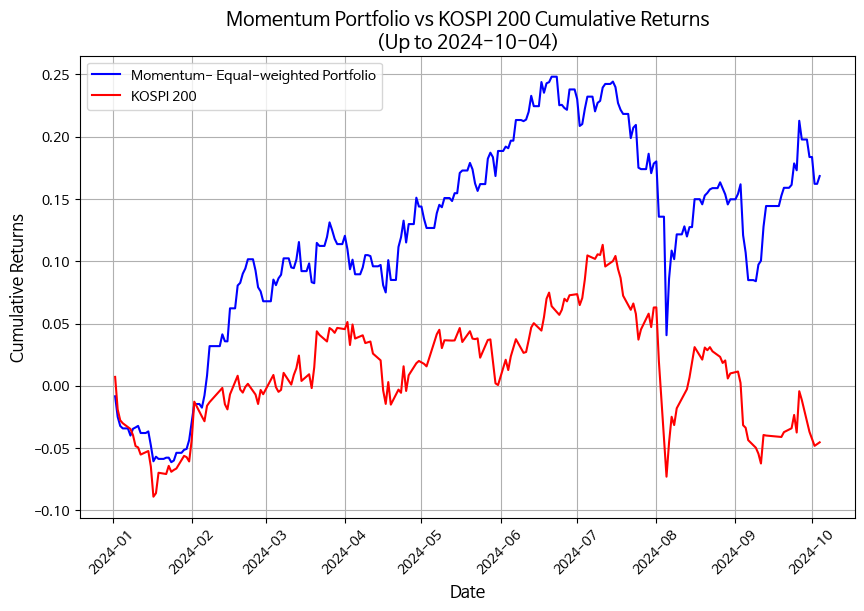

In [125]:
# 그래프 설정
plt.figure(figsize=(10, 6))
# 동일 비중 포트폴리오의 누적 수익률 시각화
plt.plot(cumulative_returns.loc['2024-01-02':'2024-10-04'], label='Momentum- Equal-weighted Portfolio', color='blue')
# 코스피200 누적 수익률 시각화
plt.plot(kospi200_cumulative_returns.loc['2024-01-02':'2024-10-04'], label='KOSPI 200', color='red')

# 그래프 제목 및 축 설정
plt.title('Momentum Portfolio vs KOSPI 200 Cumulative Returns\n(Up to 2024-10-04)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
# 날짜 라벨 회전
plt.xticks(rotation=45)

plt.legend()
plt.grid(True)
plt.show()

벤치마크는 크게 상회했으나 1% 수익률.

모멘텀 지표가 아닌 밸류지표로도 시도. (PER, PBR, EPS 등.)

# Value(PER, PBR, EPS)

In [86]:
file_path2 = ('kospi200_stocks_valuation.xlsx')
df = pd.read_excel(file_path2, sheet_name=0, header=None) # 엑셀 파일 첫 번째 시트
data_value = df.iloc[12:].reset_index(drop=True) # 12번째 행부터 데이터프레임의 데이터를 가져오도록 설정
data_value.drop(data_value.index[11], inplace=True)

data_value.columns = df.iloc[8]  # 8번째 행을 컬럼명으로 설정
data_value = data_value.rename(columns={data_value.columns[0]: 'date'})  # 첫 번째 컬럼 이름을 'date'로 변경
data_value['date'] = pd.to_datetime(data_value['date'], errors='coerce')  # 날짜 형식 변환
data_value = data_value.set_index(data_value.columns[0]) # 첫 번째 열을 인덱스로 설정하고 해당 열 제거
data_value.index = pd.to_datetime(data_value.index, errors='coerce') # 인덱스를 datetime 형식으로 변환
data_value.columns.name = 'Code'  # 종목 코드에 이름 설정
data_value.index.name = 'Date'    # 날짜 인덱스에 이름 설정
data_value.iloc[1, :] = np.nan
data_value_drop = data_value.dropna(how='all')
data_value_drop.head()

Code,A005930,A005930,A005930,A005930,A005930,A000660,A000660,A000660,A000660,A000660,...,A178920,A178920,A178920,A178920,A178920,A008730,A008730,A008730,A008730,A008730
Date,,,,,,,,,,,,,,,,,,,,,
NaT,PER(배),PBR(배),EPS(원),EBITDA(천원),ROE(영업이익)(%),PER(배),PBR(배),EPS(원),EBITDA(천원),ROE(영업이익)(%),...,PER(배),PBR(배),EPS(원),EBITDA(천원),ROE(영업이익)(%),PER(배),PBR(배),EPS(원),EBITDA(천원),ROE(영업이익)(%)
2001-01-01,8.68502,1.29733,18192.25,7588549986,21.25,NaN,0.82159,-6480,525227629,-35.81,...,NaN,NaN,NaN,NaN,NaN,3.894,0.44474,739.6,36321107,19.14
2001-01-02,9.20722,1.37534,18192.25,7588549986,21.25,NaN,0.92672,-6480,525227629,-35.81,...,NaN,NaN,NaN,NaN,NaN,3.894,0.44474,739.6,36321107,19.14
2001-01-03,9.26219,1.38355,18192.25,7588549986,21.25,NaN,0.9308,-6480,525227629,-35.81,...,NaN,NaN,NaN,NaN,NaN,3.87372,0.44242,739.6,36321107,19.14
2001-01-04,10.38904,1.55187,18192.25,7588549986,21.25,NaN,1.0696,-6480,525227629,-35.81,...,NaN,NaN,NaN,NaN,NaN,4.0292,0.46018,739.6,36321107,19.14


In [87]:
# 'PER(배)', 'PBR(배)', 'EPS(원)'인 컬럼들만 추출
per_columns = data_value_drop.iloc[0] == 'PER(배)'
pbr_columns = data_value_drop.iloc[0] == 'PBR(배)'
eps_columns = data_value_drop.iloc[0] == 'EPS(원)'

# 각각의 데이터프레임 생성
df_per = data_value_drop.loc[:, per_columns]
df_pbr = data_value_drop.loc[:, pbr_columns]
df_eps = data_value_drop.loc[:, eps_columns]

df_per.drop(df_per.index[0], inplace=True)
df_pbr.drop(df_pbr.index[0], inplace=True)
df_eps.drop(df_eps.index[0], inplace=True) ## 이거 코드 간결하게 수정해서 위에 셀에 붙여넣기.

# 1년치 데이터 사용
df_per_1st_year = df_per.loc['2023-01-01':'2023-12-31',:]
df_pbr_1st_year = df_pbr.loc['2023-01-01':'2023-12-31',:]
df_eps_1st_year = df_eps.loc['2023-01-01':'2023-12-31',:] # eps는 잘 쓰지 않는 듯 하다.

In [55]:
# df_per_1st_year

In [88]:
# PER과 PBR 값의 조건에 맞게 종목 필터링하는 함수
def filter_stocks(df_cluster, df_per, df_pbr):
    # df_per, df_pbr에 해당하는 공통 종목들만 필터링
    common_columns = df_cluster.columns.intersection(df_per.columns).intersection(df_pbr.columns)
    
    # 조건: per < 1 and pbr < 0에 해당하는 종목 필터링
    filtered_stocks = df_per[common_columns].iloc[-1][(df_per[common_columns].iloc[-1] < 1) & (df_pbr[common_columns].iloc[-1] < 0)].index.tolist()
    
    # 해당 조건을 만족하지 않는 종목을 df_cluster에서 제거
    df_filtered = df_cluster.drop(columns=filtered_stocks, errors='ignore')
    return df_filtered

# 랭킹 계산 및 상위 20개 종목 추출 함수
def rank_top_20(df_cluster, df_per, df_pbr):
    # PER 기준으로 랭킹 매기기 (오름차순)
    per_ranking = df_per.iloc[-1].rank(method='min').to_numpy()
    # PBR 기준으로 랭킹 매기기 (오름차순)
    pbr_ranking = df_pbr.iloc[-1].rank(method='min').to_numpy()
    
    # 두 랭킹 합산
    combined_ranking = per_ranking + pbr_ranking
    
    # 랭킹 기준 상위 20개 추출
    top_20_stocks = np.argsort(combined_ranking)[:20]
    return df_cluster.columns[top_20_stocks].tolist()

# 각 클러스터에 대해 필터링 및 랭킹 상위 20개 추출
def process_cluster(df_cluster, df_per, df_pbr):
    df_filtered = filter_stocks(df_cluster, df_per, df_pbr)
    
    # 필터링된 종목에 대해서만 PER과 PBR을 사용하여 랭킹을 계산
    top_20 = rank_top_20(df_filtered, df_per[df_filtered.columns], df_pbr[df_filtered.columns])
    
    return top_20

# 클러스터 0 처리
top_20_cluster_0 = process_cluster(df_cluster_0, df_per_1st_year, df_pbr_1st_year)
# 클러스터 1 처리
top_20_cluster_1 = process_cluster(df_cluster_1, df_per_1st_year, df_pbr_1st_year)
# 클러스터 2 처리
top_20_cluster_2 = process_cluster(df_cluster_2, df_per_1st_year, df_pbr_1st_year)

# 결과 출력
print("클러스터 0 상위 20개 종목:", top_20_cluster_0)
print("클러스터 1 상위 20개 종목:", top_20_cluster_1)
print("클러스터 2 상위 20개 종목:", top_20_cluster_2)

클러스터 0 상위 20개 종목: ['A024110', 'A009970', 'A001450', 'A003030', 'A005830', 'A004170', 'A005940', 'A016360', 'A300720', 'A028670', 'A032640', 'A004490', 'A161390', 'A000810', 'A138040', 'A007310', 'A017800', 'A011200', 'A010950', 'A035250']
클러스터 1 상위 20개 종목: ['A088350', 'A138930', 'A139130', 'A047040', 'A316140', 'A000880', 'A105560', 'A175330', 'A016380', 'A032830', 'A029780', 'A004020', 'A002380', 'A000720', 'A039490', 'A103140', 'A030200', 'A001120', 'A003550', 'A003490']
클러스터 2 상위 20개 종목: ['A078930', 'A086790', 'A055550', 'A010060', 'A071050', 'A375500', 'A001430', 'A012330', 'A000240', 'A005380', 'A111770', 'A023530', 'A000270', 'A001800', 'A006260', 'A005850', 'A241560', 'A192080', 'A004000', 'A069260']


            Cluster 0 Cumulative Returns (Extended)  \
2024-01-01                                      NaN   
2024-01-02                                -0.009776   
2024-01-03                                -0.022350   
2024-01-04                                -0.027151   
2024-01-05                                -0.032609   
...                                             ...   
2024-10-03                                 0.102720   
2024-10-04                                 0.102183   
2024-10-05                                 0.102183   
2024-10-06                                 0.102183   
2024-10-07                                 0.112886   

            Cluster 1 Cumulative Returns (Extended)  \
2024-01-01                                      NaN   
2024-01-02                                -0.011069   
2024-01-03                                -0.026458   
2024-01-04                                -0.036833   
2024-01-05                                -0.042418   
...      

<Axes: title={'center': 'Cumulative Returns Comparison (2024년 10월 4일까지)'}>

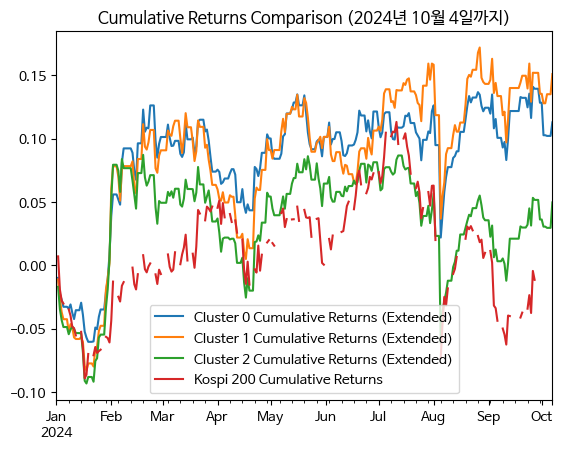

In [89]:
# 2024년 10월 4일까지 확장된 동일 비중 포트폴리오의 누적 수익률을 계산하는 함수
def calculate_extended_cumulative_returns(data, top_20_stocks, start_date):
    # data에서 상위 20개의 종목에 해당하는 종가 데이터만 추출 (start_date 이후)
    df_top_20 = data[top_20_stocks].loc[start_date:]
    
    # 종가 데이터에서 일일 수익률 계산 (pct_change로 일일 변동률 계산)
    returns = df_top_20.pct_change().mean(axis=1)  # 동일 비중으로 평균 수익률 계산
    
    # 누적 수익률 계산 (cumprod로 누적 곱 계산)
    cumulative_returns = (1 + returns).cumprod() -1
    
    return cumulative_returns

# 클러스터 0의 2024년 10월 4일까지의 누적 수익률 계산
extended_cumulative_returns_cluster_0 = calculate_extended_cumulative_returns(data, top_20_cluster_0, start_date='2024-01-01')

# 클러스터 1의 2024년 10월 4일까지의 누적 수익률 계산
extended_cumulative_returns_cluster_1 = calculate_extended_cumulative_returns(data, top_20_cluster_1, start_date='2024-01-01')

# 클러스터 2의 2024년 10월 4일까지의 누적 수익률 계산
extended_cumulative_returns_cluster_2 = calculate_extended_cumulative_returns(data, top_20_cluster_2, start_date='2024-01-01')

# Kospi 200의 누적 수익률과 비교
comparison_df_extended = pd.DataFrame({
    'Cluster 0 Cumulative Returns (Extended)': extended_cumulative_returns_cluster_0,
    'Cluster 1 Cumulative Returns (Extended)': extended_cumulative_returns_cluster_1,
    'Cluster 2 Cumulative Returns (Extended)': extended_cumulative_returns_cluster_2,
    'Kospi 200 Cumulative Returns': kospi200_cumulative_returns.loc['2024-01-01':]
})

# 비교 결과 출력
print(comparison_df_extended)

# 시각화를 통해 비교 (선택사항)
comparison_df_extended.plot(title="Cumulative Returns Comparison (2024년 10월 4일까지)")

            Top 30 Cumulative Returns  Kospi 200 Cumulative Returns
2024-01-01                        NaN                           NaN
2024-01-02                  -0.016434                      0.007151
2024-01-03                  -0.029142                     -0.018967
2024-01-04                  -0.040132                     -0.027710
2024-01-05                  -0.044143                     -0.030085
...                               ...                           ...
2024-10-03                   0.093179                           NaN
2024-10-04                   0.097223                     -0.045392
2024-10-05                   0.097223                           NaN
2024-10-06                   0.097223                           NaN
2024-10-07                   0.114437                           NaN

[281 rows x 2 columns]


<Axes: title={'center': 'Cumulative Returns Comparison: Top 30 vs Kospi 200 (2024년 10월 4일까지)'}>

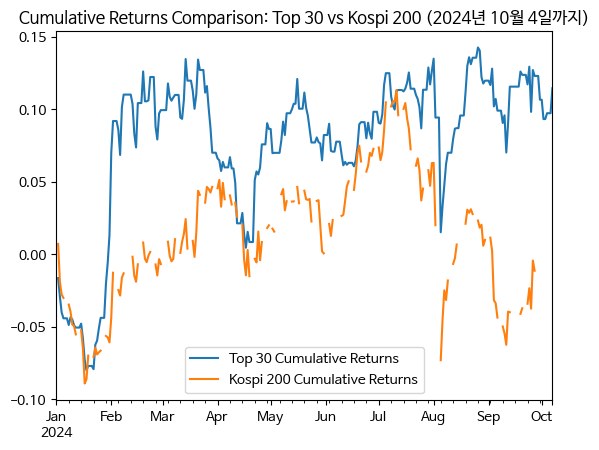

In [90]:
# 클러스터를 합친 후 상위 10개 종목을 뽑는 함수
def get_top_10_stocks_from_clusters(clusters, df_per, df_pbr):
    combined_stocks = []
    
    for df_cluster in clusters:
        # 클러스터 내에서 종목 필터링 및 랭킹 상위 10개 종목 추출
        df_filtered = filter_stocks(df_cluster, df_per, df_pbr)
        top_10 = rank_top_20(df_filtered, df_per[df_filtered.columns], df_pbr[df_filtered.columns])[:10]
        combined_stocks.extend(top_10)
    
    return combined_stocks

# 클러스터 1, 2, 3을 합쳐서 상위 10개씩 추출
clusters = [df_cluster_0, df_cluster_1, df_cluster_2]
top_30_stocks = get_top_10_stocks_from_clusters(clusters, df_per_1st_year, df_pbr_1st_year)

# 중복 종목 제거
top_30_stocks_unique = list(set(top_30_stocks))

# 상위 30개 종목의 2024년 10월 4일까지의 누적 수익률을 계산하는 함수
def calculate_cumulative_returns_for_top_30(data, top_30_stocks, start_date):
    df_top_30 = data[top_30_stocks].loc[start_date:]
    
    # 일일 수익률 계산 (동일 비중 포트폴리오)
    returns = df_top_30.pct_change().mean(axis=1)
    
    # 누적 수익률 계산
    cumulative_returns = (1 + returns).cumprod() -1
    
    return cumulative_returns

# 상위 30개 종목의 2024년 10월 4일까지의 누적 수익률 계산
cumulative_returns_top_30 = calculate_cumulative_returns_for_top_30(data, top_30_stocks_unique, start_date='2024-01-01')

# Kospi 200의 누적 수익률과 비교
comparison_df_top_30 = pd.DataFrame({
    'Top 30 Cumulative Returns': cumulative_returns_top_30,
    'Kospi 200 Cumulative Returns': kospi200_cumulative_returns.loc['2024-01-01':]
})

# 비교 결과 출력
print(comparison_df_top_30)

# 시각화를 통해 비교
comparison_df_top_30.plot(title="Cumulative Returns Comparison: Top 30 vs Kospi 200 (2024년 10월 4일까지)")


In [104]:
# print(cumulative_returns)
# print(cumulative_returns_top_30)
# print(kospi200_cumulative_return)
cumulative_returns_top_30.dropna(inplace=True)

In [112]:
# 주말을 포함한 전체 날짜 범위 생성
# kospi200_cumulative_returns의 시작 날짜와 끝 날짜에 해당하는 범위로 생성
full_date_range = pd.date_range(start=kospi200_cumulative_returns.index.min(), 
                                end=kospi200_cumulative_returns.index.max(), 
                                freq='D')

# 주말 포함한 날짜로 리인덱스 (NaN 값으로 채워짐)
kospi200_cumulative_returns_full = kospi200_cumulative_returns.reindex(full_date_range)
kospi200_cumulative_returns_full.fillna(method='ffill', inplace = True)

# 결과 확인
kospi200_cumulative_returns_full.head()
# 이 코드 kospi정보 가져올때부터 적용하는걸로 수정.

2024-01-02    0.007151
2024-01-03   -0.018967
2024-01-04   -0.027710
2024-01-05   -0.030085
2024-01-06   -0.030085
Freq: D, Name: Adj Close, dtype: float64

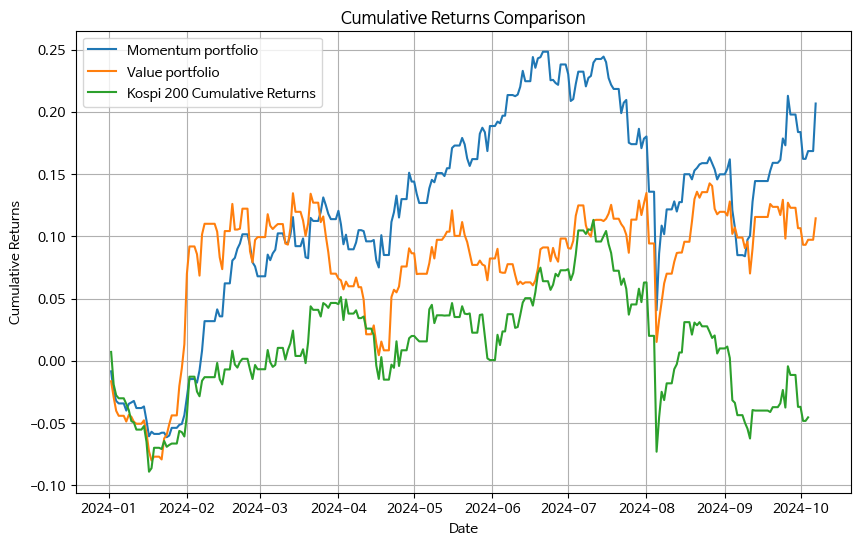

In [126]:
# 세 가지 누적 수익률 데이터프레임을 하나로 합침
comparison_df = pd.DataFrame({
    'Cluster Cumulative Returns': cumulative_returns,  # 클러스터 포트폴리오 누적 수익률
    'Top 30 Cumulative Returns': cumulative_returns_top_30,  # 상위 30개 종목의 누적 수익률
    'Kospi 200 Cumulative Returns': kospi200_cumulative_returns_full  # 코스피 200 누적 수익률
})

# 누적 수익률 시각화
plt.figure(figsize=(10, 6))
plt.plot(comparison_df.index, comparison_df['Cluster Cumulative Returns'], label='Momentum portfolio', linestyle='-')
plt.plot(comparison_df.index, comparison_df['Top 30 Cumulative Returns'], label='Value portfolio', linestyle='-')
plt.plot(comparison_df.index, comparison_df['Kospi 200 Cumulative Returns'], label='Kospi 200 Cumulative Returns', linestyle='-')

# 그래프 꾸미기
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')
plt.grid(True)

# 그래프 출력 # 단순 수익률은 모멘텀이 좋지만 하락장에서 하락폭이 더 큰 모습. 샤프비율을 확인해보자.
plt.show()

In [135]:
# 상위 30개 종목의 2024년 10월 4일까지의 누적 수익률을 계산하는 함수
def returns_for_top_30_value(data, top_30_stocks, start_date):
    df_top_30 = data[top_30_stocks].loc[start_date:]
    
    # 일일 수익률 계산 (동일 비중 포트폴리오)
    returns = df_top_30.pct_change().mean(axis=1)
    
    return returns


# 무위험 이자율 설정 (예: 2% 연간 수익률)
risk_free_rate = 0.02

# 각 데이터프레임에서 일일 수익률 계산
daily_returns_top_30_momentum = equal_weight_returns.pct_change().dropna().mean()  # axis=1 제거
daily_returns_top_30_value = returns_for_top_30_value(data, top_30_stocks_unique, start_date='2024-01-01')
daily_returns_kospi200 = kospi_200.pct_change().dropna().mean()  # axis=1 제거

## 이거 함수 다시 정리해서 --> 아래 내용 표로 만들어두기.

In [138]:
# # 연간 변동성 계산 (일간 변동성 * sqrt(252))
# volatility_mom = daily_returns_top_30_momentum.std() * (252 ** 0.5)
# volatility_value = daily_returns_top_30_value.std() * (252 ** 0.5)
# volatility_ks = daily_returns_kospi200.std() * (252 ** 0.5)

# # 연간 평균 수익률 계산
# annual_return_mom = daily_returns_top_30_momentum.mean() * 252
# annual_return_value = daily_returns_top_30_value.mean() * 252
# annual_return_kospi200 = daily_returns_kospi200.mean() * 252

# # 샤프 비율 계산
# sharpe_ratio_mom = (annual_return_mom - risk_free_rate) / volatility_mom
# sharpe_ratio_value = (annual_return_value - risk_free_rate) / volatility_value
# sharpe_ratio_kospi200 = (annual_return_kospi200 - risk_free_rate) / volatility_ks

# # 결과 출력
# print(f"변동성 (모멘텀): {volatility_mom:.4f}")
# print(f"샤프 비율 (모멘텀): {sharpe_ratio_mom:.4f}")
# print(f"변동성 (밸류): {volatility_value:.4f}")
# print(f"샤프 비율 (밸류): {sharpe_ratio_value:.4f}")
# print(f"변동성 (코스피 200): {volatility_ks:.4f}")
# print(f"샤프 비율 (코스피 200): {sharpe_ratio_kospi200:.4f}")